In [10]:
%pip install polars matplotlib numpy pandas seaborn scikit-learn pyarrow biopython ete3 PyQt5 statsmodels
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re
from Bio import SeqIO
from matplotlib import gridspec
import string
import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_theme(context="paper")

Note: you may need to restart the kernel to use updated packages.


How many by classification?

What is the proportion of MADA and CJID motifs?

# Expression analysis

Couple of things to check here.
* Are there differentially expressed NLRs across the different conditions?
* Are there broad changes in NLR expression between conditions?
* Are helixer predictions significantly differentially expressed?
  
Need to do some stats in between these


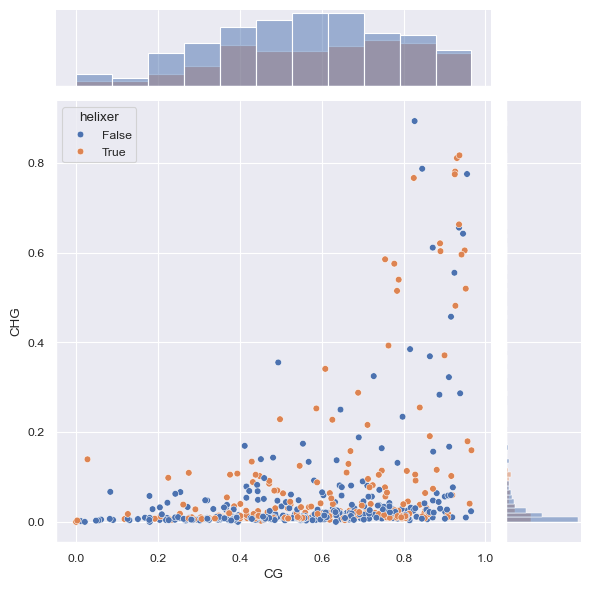

In [15]:
subfeature_methylation = (
    pl.read_csv("../results/subfeature_methylation.csv")
    .with_columns(pl.col("gene").str.replace(r"\.\d$", "").alias("gene"))
    .with_columns(
        pl.col("gene").is_in(canonical_nlrs).alias("canonical"),
    )
    .join(resistify_result, on="gene", how="inner")

)

g = sns.JointGrid(
    (
        subfeature_methylation
        .filter(pl.col("canonical"))
        .filter(pl.col("column_3") == "exon")
        .pivot(index=["gene", "helixer"], columns="type", values="weighted_mean") 
    ),
    x="CG",
    y="CHG",
    hue="helixer",
)
g.plot(sns.scatterplot, sns.histplot)

Transposable element overlaps

In [7]:
earlgrey_overlaps = (
    pl.read_csv(
        "../results/final_annotation/final_annotation.longest.earlgrey_overlap.bed",
        separator="\t",
        has_header=False,
    )
    .filter(pl.col("column_4").is_in(canonical_nlrs))
    .select(chrom=pl.col("column_10"), start=pl.col("column_11"), end=pl.col("column_12"))
    .join(
        (
            pl.read_csv(
                "../results/earlgrey/solanum_verrucosum_summaryFiles/solanum_verrucosum.filteredRepeats.gff",
                separator="\t",
                has_header=False,
            )
            .with_columns(
                pl.col("column_9").str.extract(r"ID=(.*?);").alias("ID"),
            )
            .select(chrom=pl.col("column_1"), start=pl.col("column_4"), end=pl.col("column_5"), ID=pl.col("ID"))
        ),
        on=["chrom", "start", "end"],
        how="full",
    )
)

earlgrey_overlaps

chrom,start,end,chrom_right,start_right,end_right,ID
str,i64,i64,str,i64,i64,str
null,null,null,"""chr08""",2,40,"""RND-2_FAMILY-121"""
null,null,null,"""chr08""",41,700,"""RND-5_FAMILY-11144"""
null,null,null,"""chr08""",701,972,"""RND-5_FAMILY-11144"""
null,null,null,"""chr08""",973,1177,"""RND-5_FAMILY-11144"""
null,null,null,"""chr08""",1178,1525,"""RND-5_FAMILY-11144"""
…,…,…,…,…,…,…
null,null,null,"""scaffold_999""",26441,26521,"""A-RICH"""
null,null,null,"""scaffold_999""",26522,26536,"""(AGAA)N"""
null,null,null,"""scaffold_999""",28806,28839,"""(TATAGA)N"""
